In [56]:
# Enable interactive plots
import numpy as np
from stl import mesh
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Define a highly non-convex function with a unique global minimum
def non_convex_function(X):
    """
    Creates a highly non-convex landscape with peaks, saddle points, 
    and a single unique global minimum at (x_min, y_min).
    """
    x, y = X
    x_min, y_min = 0, 0  # Define global minimum location
    global_min = -3 * np.exp(-0.4 * ((x - x_min) ** 2 + (y - y_min) ** 2))  # Very deep valley at (0,0)

    peaks = (np.sin(x) * np.cos(y) +    # Broad waves
             2 * np.exp(-0.3 * ((x + 3) ** 2 + (y - 2) ** 2)) -  # Large peak
             1.5 * np.exp(-0.2 * ((x - 4) ** 2 + (y + 4) ** 2))  # Another peak
             )
    return global_min + peaks

# Compute numerical gradient
def gradient(x, y, h=1e-5):
    df_dx = (non_convex_function([x + h, y]) - non_convex_function([x - h, y])) / (2 * h)
    df_dy = (non_convex_function([x, y + h]) - non_convex_function([x, y - h])) / (2 * h)
    return np.array([df_dx, df_dy])

# Steepest descent function with boundary constraints
def steepest_descent(x0, y0, lr=0.1, max_iters=200, tol=1e-5):
    trajectory = [(x0, y0)]
    for _ in range(max_iters):
        grad = gradient(x0, y0)
        step = -lr * grad  # Move in the direction of negative gradient
        x0, y0 = x0 + step[0], y0 + step[1]
        
        # Enforce boundary constraints
        x0 = np.clip(x0, -6,6)
        y0 = np.clip(y0, -6,6)
        
        trajectory.append((x0, y0))
        if np.linalg.norm(grad) < tol:  # Stop if gradient is small
            break
    return np.array(trajectory)

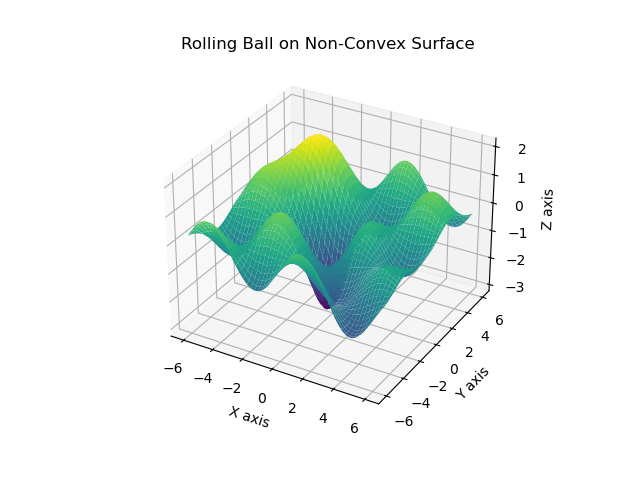

In [57]:
%matplotlib widget
# Generate hexagonal grid for surface
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = non_convex_function([X, Y])

# Plotting the surface (for visualization)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Rolling Ball on Non-Convex Surface')

# Show plot
plt.show()

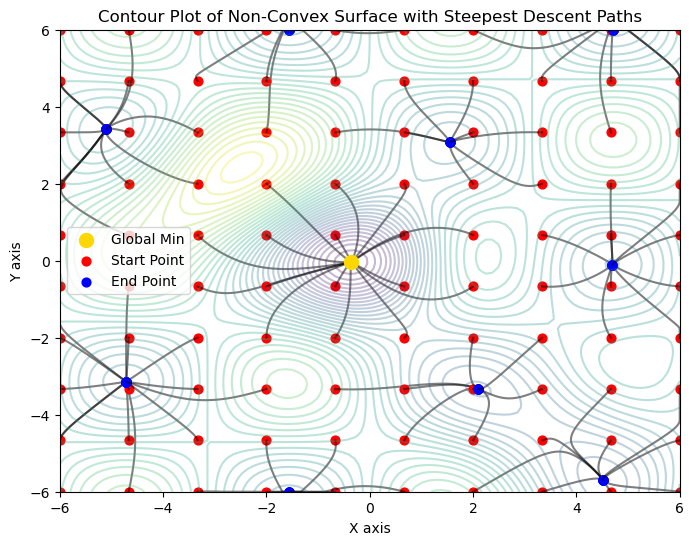

In [58]:
plt.close()
%matplotlib inline

# Generate a heatmap
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.3)
plt.title('Contour Plot of Non-Convex Surface with Steepest Descent Paths')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# Generate starting points on a grid and run steepest descent
num_starting_points = 10
start_x = np.linspace(-6, 6, num_starting_points)
start_y = np.linspace(-6, 6, num_starting_points)

# Use scipy's minimize function to find the global minimum
result = minimize(non_convex_function, x0=[0, 0], bounds=[(-6, 6), (-6, 6)])

# Extract the global minimum coordinates
global_min_x, global_min_y = result.x
plt.scatter(global_min_x, global_min_y, c='gold', s=100, label='Global Min', zorder=3)

for x0 in start_x:
    for y0 in start_y:
        traj = steepest_descent(x0, y0)
        plt.scatter(traj[0, 0], traj[0, 1], c='red', s=40, label='Start Point' if (x0 == start_x[0] and y0 == start_y[0]) else "")  # Start points
        plt.scatter(traj[-1, 0], traj[-1, 1], c='blue', s=40, label='End Point' if (x0 == start_x[0] and y0 == start_y[0]) else "")  # End points
        plt.plot(traj[:, 0], traj[:, 1], 'k-', alpha=0.5, zorder=1)  # White lines for descent paths (zorder=1 to send to back)

plt.legend()
plt.show()


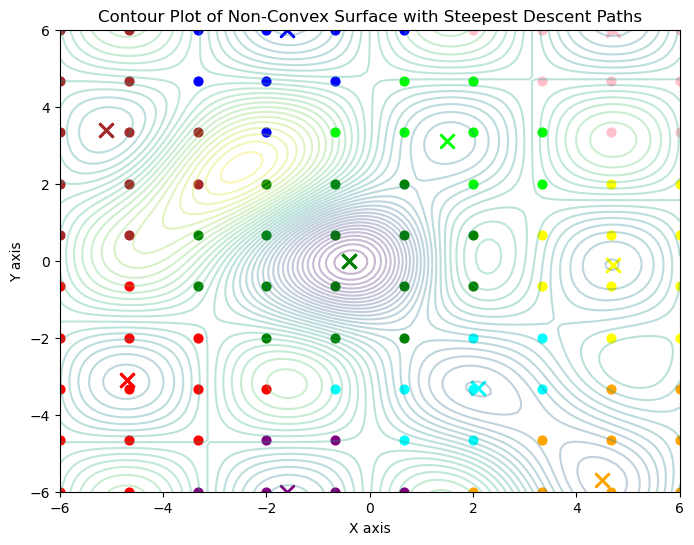

In [59]:
plt.close()
%matplotlib inline

# Generate a grid of starting points
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.3)
plt.title('Contour Plot of Non-Convex Surface with Steepest Descent Paths')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# Pre-compute basins using scipy.optimize.minimize
basin_colors = np.zeros_like(X, dtype=int)
color_map = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'pink', 'brown', 'lime', 'magenta', 'teal', 'gray'])
basin_to_color = {}
color_index = 0

# Iterate over each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        # Use minimize to find the final point
        result = minimize(non_convex_function, x0=[X[i, j], Y[i, j]], bounds=[(-6,6), (-6,6)])
        end_point = tuple(np.round(result.x, decimals=1))  # Round to avoid floating-point issues
        
        # Assign a unique color to each basin
        if end_point not in basin_to_color:
            basin_to_color[end_point] = color_index
            color_index = (color_index + 1) % len(color_map.colors)

        # Assign the color index to the basin_colors grid
        basin_colors[i, j] = basin_to_color[end_point]

# Run steepest descent for starting points and color them based on the basin they reach
num_starting_points = 10
start_x = np.linspace(-6, 6, num_starting_points)
start_y = np.linspace(-6, 6, num_starting_points)

for x0 in start_x:
    for y0 in start_y:
        traj = steepest_descent(x0, y0)
        end_point = tuple(np.round(traj[-1], decimals=1))  # Round to avoid floating-point issues
        
        # Round the end_point to ensure it's consistent with the keys in basin_to_color
        rounded_end_point = tuple(np.round(end_point, decimals=1))
        
        # Get the color of the basin
        if rounded_end_point in basin_to_color:
            color = color_map.colors[basin_to_color[rounded_end_point]]  # Get the color of the basin
            plt.scatter(x0, y0, c=[color], s=40)  # Color the starting point based on the basin
            
            # Add a cross at the basin position with the corresponding color
            plt.scatter(rounded_end_point[0], rounded_end_point[1], c=[color], marker='x', s=100)
        else:
            print(f"End point {rounded_end_point} not found in basin_to_color")

plt.show()


In [61]:
# Set Z = -3 on the boundaries
Z[0:3, :] = 2  # Top boundary
Z[-3:-1, :] = 2  # Bottom boundary
Z[:, 0:3] = 2  # Left boundary
Z[:, -3:-1] = 2  # Right boundary

Z[0, :] = -3  # Top boundary
Z[-1, :] = -3  # Bottom boundary
Z[:, 0] = -3  # Left boundary
Z[:, -1] = -3  # Right boundary

# Create the vertices for the surface mesh (X, Y, Z)
vertices = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# Generate the faces (triangles) for the grid
faces = []
for i in range(len(x) - 1):
    for j in range(len(y) - 1):
        # Create two triangles for each grid cell
        faces.append([i * len(y) + j, (i + 1) * len(y) + j, i * len(y) + j + 1])
        faces.append([(i + 1) * len(y) + j, (i + 1) * len(y) + j + 1, i * len(y) + j + 1])

# Convert faces to a numpy array
faces = np.array(faces)

# Create the mesh using numpy-stl
surface_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))

for i, f in enumerate(faces):
    for j in range(3):
        surface_mesh.vectors[i][j] = vertices[f[j]]

# Save the mesh as an STL file
surface_mesh.save('non_convex_surface.stl')
